In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats

In [2]:
cd CSVs

/Users/ritusinghal/Desktop/Metis/mta-project-1/CSVs


#### Load Data

In [3]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])
data


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,00:00:00,REGULAR,7053483,2390505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,04:00:00,REGULAR,7053511,2390508
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,08:00:00,REGULAR,7053534,2390536
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,12:00:00,REGULAR,7053618,2390596
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,16:00:00,REGULAR,7053841,2390655
...,...,...,...,...,...,...,...,...,...,...,...
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,05:00:00,REGULAR,5554,376
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,09:00:00,REGULAR,5554,376
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,13:00:00,REGULAR,5554,376
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,17:00:00,REGULAR,5554,376


#### Clean Data

remove spaces from column names

In [4]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [5]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile column (Combining SCP,C/A, Station and Unit)

In [6]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']

Group by date and Turnstile

In [7]:
grouped_day = data.groupby(['DATE','Turnstile','STATION'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = data.groupby(['STATION','DATE']).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = grouped.set_index('STATION')
#grouped.head()

In [8]:
grouped_day.head()

DATE              Turnstile STATION  ENTRIES             EXITS  \
                                                  min      max      min   
0  03/30/2019  A002R05102-00-0059 ST   59 ST  6999064  6999796  2373568   
1  03/30/2019  A002R05102-00-0159 ST   59 ST  6238770  6239372  1399138   
2  03/30/2019  A002R05102-03-0059 ST   59 ST  1211476  1211761  4553166   
3  03/30/2019  A002R05102-03-0159 ST   59 ST  1049198  1049913  1621305   
4  03/30/2019  A002R05102-03-0259 ST   59 ST  6132784  6133502  8279411   

            
       max  
0  2373837  
1  1399289  
2  4554337  
3  1622549  
4  8280248

In [9]:
#grouped.columns = [ 'Station', 'Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
grouped_day.columns = [ 'Date', 'Turnstile', 'Station','ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.columns = ['ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.dtypes

Add weekday column

In [10]:
grouped_day['Date'] = pd.to_datetime(grouped_day['Date'], cache=True)
grouped_day['Week_Day'] = grouped_day['Date'].dt.day_name()

Find total entries exits, and traffic

In [11]:
grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Entries']
grouped_day.head()

,Date,Turnstile,Station,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic
0,2019-03-30,A002R05102-00-0059 ST,59 ST,6999064,6999796,2373568,2373837,Saturday,732,269,1001
1,2019-03-30,A002R05102-00-0159 ST,59 ST,6238770,6239372,1399138,1399289,Saturday,602,151,753
2,2019-03-30,A002R05102-03-0059 ST,59 ST,1211476,1211761,4553166,4554337,Saturday,285,1171,1456
3,2019-03-30,A002R05102-03-0159 ST,59 ST,1049198,1049913,1621305,1622549,Saturday,715,1244,1959
4,2019-03-30,A002R05102-03-0259 ST,59 ST,6132784,6133502,8279411,8280248,Saturday,718,837,1555


In [12]:
grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)



,Date,Turnstile,Station,Week_Day,Total_Traffic
0,2019-03-30,A002R05102-00-0059 ST,59 ST,Saturday,1001
1,2019-03-30,A002R05102-00-0159 ST,59 ST,Saturday,753
2,2019-03-30,A002R05102-03-0059 ST,59 ST,Saturday,1456
3,2019-03-30,A002R05102-03-0159 ST,59 ST,Saturday,1959
4,2019-03-30,A002R05102-03-0259 ST,59 ST,Saturday,1555
...,...,...,...,...,...
372442,2019-06-14,TRAM2R46900-00-01RIT-ROOSEVELT,RIT-ROOSEVELT,Friday,1599
372443,2019-06-14,TRAM2R46900-03-00RIT-ROOSEVELT,RIT-ROOSEVELT,Friday,254
372444,2019-06-14,TRAM2R46900-03-01RIT-ROOSEVELT,RIT-ROOSEVELT,Friday,259
372445,2019-06-14,TRAM2R46900-05-00RIT-ROOSEVELT,RIT-ROOSEVELT,Friday,0


Removing Outlier data from Total_traffic column (Removing anything outside 3 sigma)

In [13]:
grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

In [14]:
#grouped_time = data.sort_values(['Date_Time']).groupby(['Turnstile','STATION','DIVISION','Date_Time'],as_index = False).agg({'ENTRIES': ['diff'], 'EXITS': ['diff']})

In [20]:
grouped_time = data
grouped_time.sort_values(['Turnstile','Date_Time'],inplace = True)
#grouped_time.head(5)
#entry_vals = grouped_time['ENTRIES'].values
#exit_vals = grouped_time['EXITS'].values
#len(entry)
#len (entry_vals[:-1])
#len (entry_vals[1:])
#diffs_entry = entry_vals[1:] - entry_vals[:-1]
#diffs_exit = exit_vals[1:] - exit_vals[:-1]
#diffs_entry = np.append(diffs_entry,0)
#diffs_exit = np.append(diffs_exit,0)
grouped_time['diffs_entry'] = grouped_time.groupby(['Turnstile'])['ENTRIES'].diff()
#grouped_time['diffs_exit'] = grouped_time.groupby(['Turnstile'])['EXITS'].diff()
#mask = !((grouped_time['diffs_entry'] == 0) && (grouped_time['diffs_exit'] == 0))
#mask =   grouped_time['diffs_entry'] == 0
#grouped_time = grouped_time[grouped_time['diffs_entry'] ]
#grouped_time['diffs_entry'] = grouped_time.rolling_apply(data['ENTRIES'], 2, lambda x: x[1] - x[0])
#grouped_time['diffs_exit'] = grouped_time.rolling_apply(data['EXITS'], 2, lambda x: x[1] - x[0])
#grouped_time.head()
#mask
grouped_time.head()

ValueError: cannot reindex from a duplicate axis

In [19]:
entry_vals = grouped_time['ENTRIES'].values
entry_vals[1:]

array([6999084, 6999107, 6999214, ...,    5554,    5554,    5554])

In [12]:
#grouped_time = data.groupby(['STATION','TIME'], as_index=False).agg({'ENTRIES': ['diff'], 'EXITS': ['diff']})
#grouped_time.head()
#grouped_time.columns = ['Station', 'Time', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']


In [18]:
grouped_time['Total_Entries'] = grouped_time['ENTRIES_MAX'] - grouped_time['ENTRIES_MIN']
grouped_time['Total_Exits'] = grouped_time['EXITS_MAX'] - grouped_time['EXITS_MIN']
grouped_time['Total_Traffic'] = grouped_time['Total_Exits'] + grouped_time['Total_Entries']
grouped_time.head()

NameError: name 'grouped_time' is not defined

In [14]:
grouped_time.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)

,Station,Time,Total_Traffic
0,1 AV,00:00:00,1997533402
1,1 AV,04:00:00,1997533422
2,1 AV,07:41:30,1997326314
3,1 AV,07:54:19,774465172
4,1 AV,07:54:45,774493648
...,...,...,...
99249,ZEREGA AV,05:00:00,826182
99250,ZEREGA AV,09:00:00,826254
99251,ZEREGA AV,13:00:00,826340
99252,ZEREGA AV,17:00:00,826496


In [15]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['Total_Traffic'])) < 3)] #filtering

#### Combine data

### Finding top 10 visited stations

In [22]:
Total_ridership = grouped_day.groupby(['Station']).Total_Traffic.sum().reset_index()

In [23]:
Total_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)


In [24]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.Total_Traffic 
    station_list = rows.Station
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(10)


,Station,Total_Traffic
61,34 ST-PENN STA,20734373
232,GRD CNTRL-42 ST,18391690
314,PATH NEW WTC,18131327
59,34 ST-HERALD SQ,14225716
46,23 ST,12846093
14,14 ST-UNION SQ,12782450
257,JOURNAL SQUARE,11775822
352,TIMES SQ-42 ST,11659807
68,42 ST-PORT AUTH,11414255
225,FULTON ST,11395719


<BarContainer object of 10 artists>

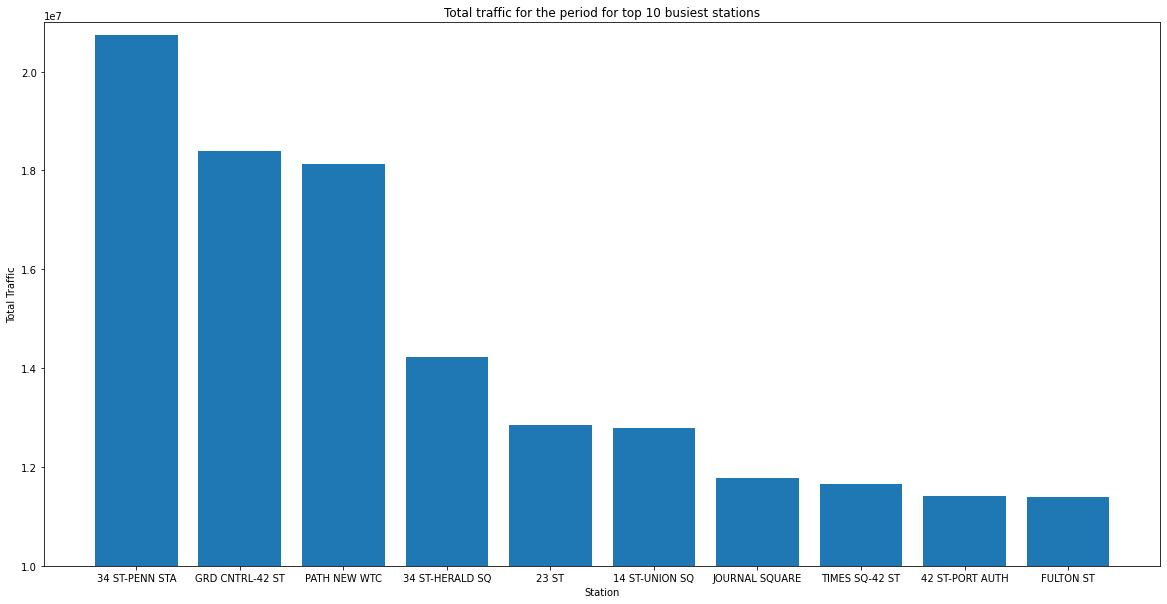

In [27]:
plt.ylim(10000000,21000000)
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.title("Total traffic for the period for top 10 busiest stations")
plt.bar(indices, Row_list)

Top 10 Busy Stations, We will focus on top5 of these.

In [28]:
indices

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 'PATH NEW WTC',
 '34 ST-HERALD SQ',
 '23 ST',
 '14 ST-UNION SQ',
 'JOURNAL SQUARE',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH',
 'FULTON ST']

### Find high traffic days

In [30]:
Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.sum().reset_index()
#Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.mean().reset_index()
Total_Weekly_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)
Total_Weekly_ridership.head()

,Week_Day,Total_Traffic
5,Tuesday,137062172
6,Wednesday,128188174
4,Thursday,125522870
0,Friday,120780404
1,Monday,114242470


<BarContainer object of 7 artists>

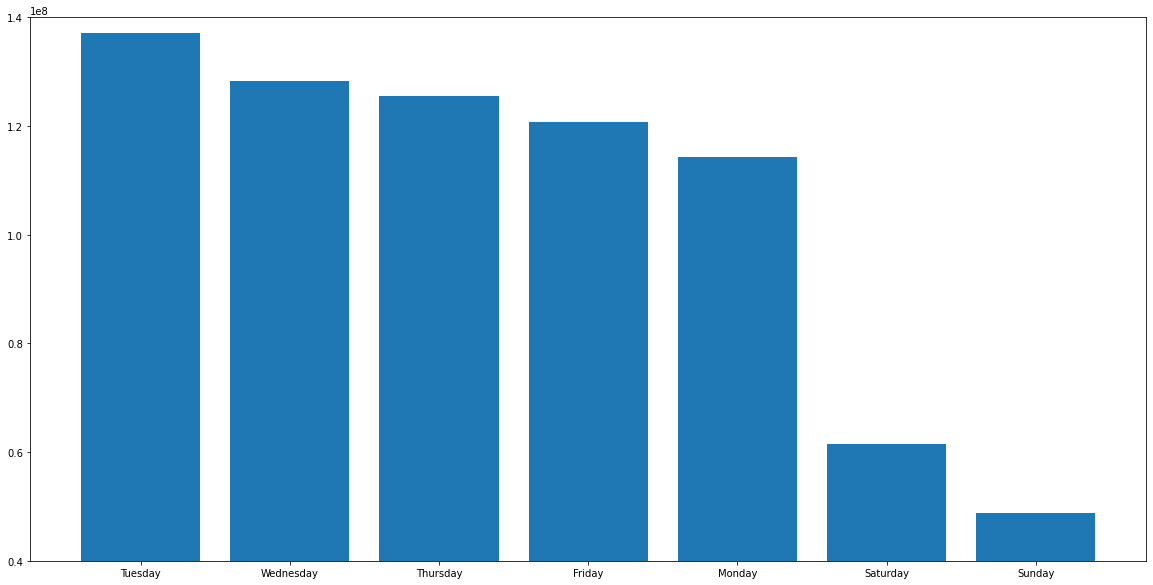

In [32]:
#plt.ylim(1610000000000,1620000000000)
plt.ylim(40000000,140000000)
plt.bar(Total_Weekly_ridership['Week_Day'], Total_Weekly_ridership['Total_Traffic'])

Based on this it seems like weekends see much less traffic compared to weekdays. So WWTF should focus more on weekdays 

In [39]:
Top5 = Total_ridership['Station'][0:5].tolist()
Top5_stations = grouped_day[grouped_day['Station'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['Station','Date']).Total_Traffic.sum().reset_index()
#Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.mean().reset_index()

#### Weekly Plot for Top5 stations

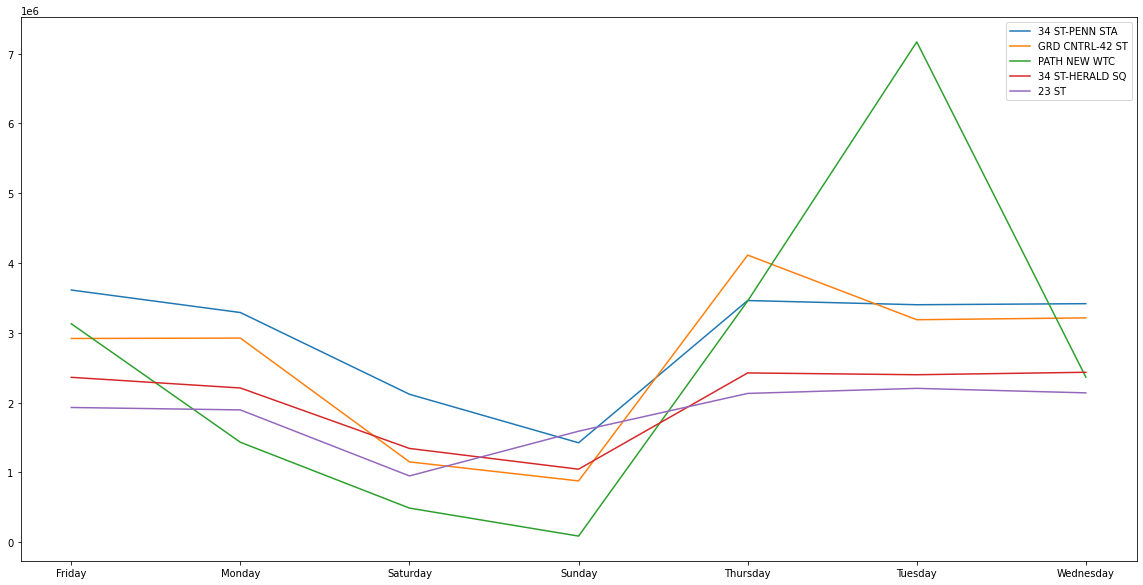

In [37]:

for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
    plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()



Looking at the plot seems like top5 stations are also showing a dip on weekends, but PATH NEW WTC station is oblitrating seeing the trend properly. This needs to be investigated further. Also, to see the trend for rest of the station we will do another plot removing the data for PATH NEW WTC

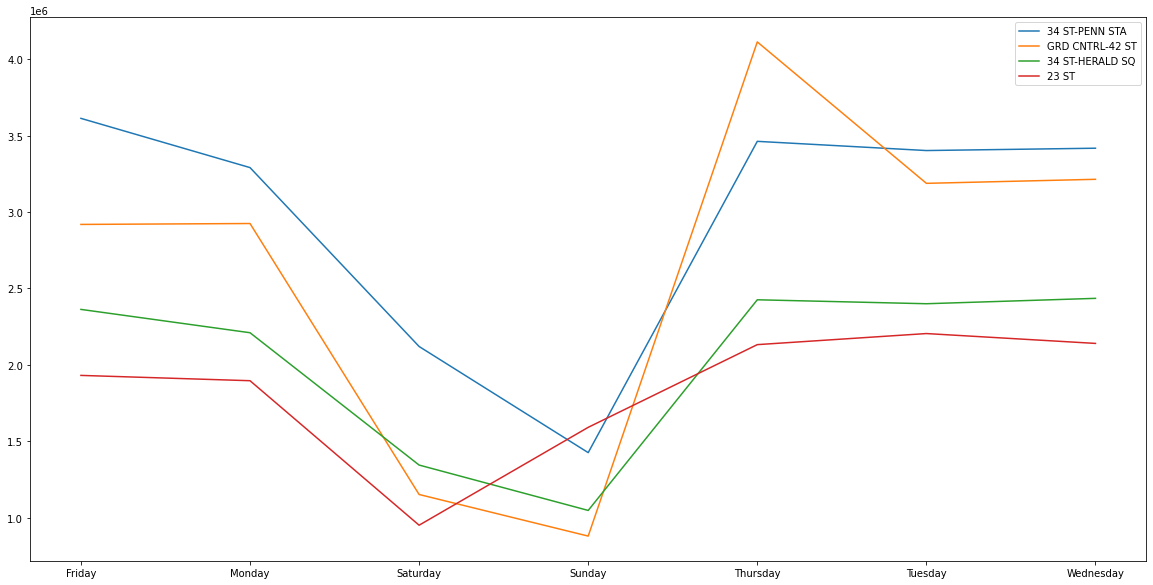

In [38]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
        plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This is also showing the dip in weekend more clearly. But GRD CNTRL-42 ST shows peak on thursday - which needs to be investigated.

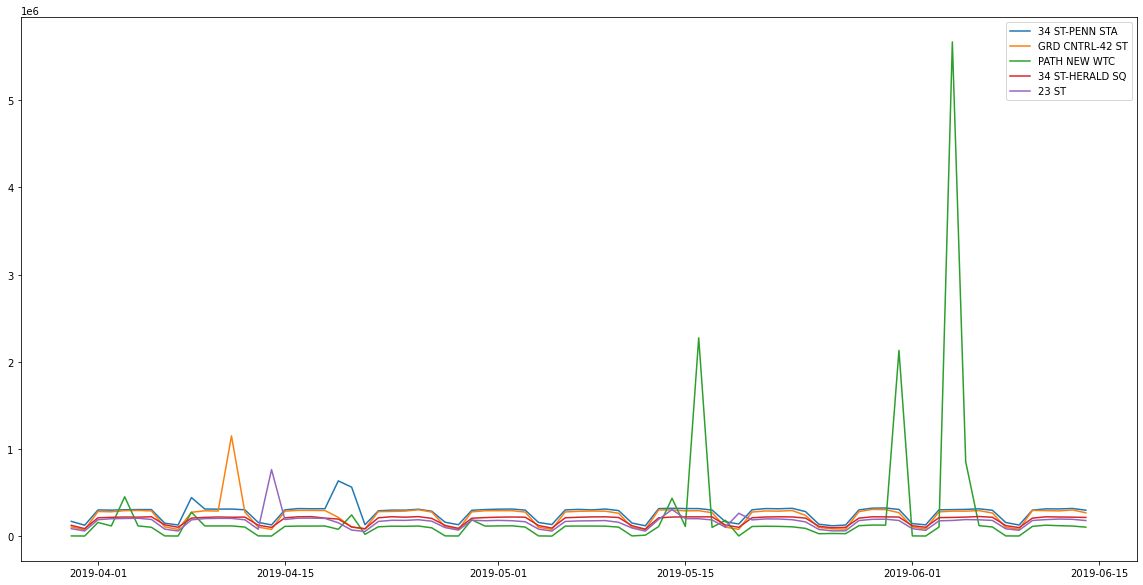

In [40]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
    plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot is also showing some abnormal values for some of the days for PATH NEW WTC. Two of these dates are looking on thursdays. We will look at rest of the stations removing PATH NEW WTC

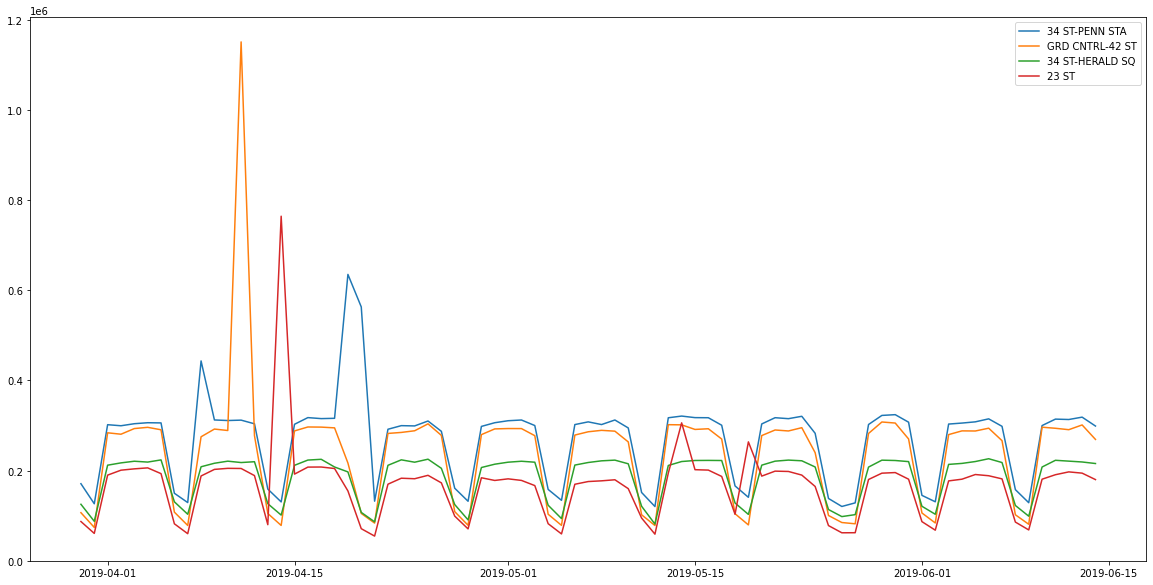

In [41]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
        plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot also seems to have some outliers. But In general trend is clear Traffic takes a dip on weekends and remains kind of static on weekdays

### Find peak hours

### Find high traffic areas for games

### Find top stations in each area code

In [96]:
loc_data = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
print(loc_data.Borough.unique())
loc_data.tail()

['Q' 'M' 'Bk' 'Bx' 'SI']


,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville,0,NaN
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville,0,NaN
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville,0,NaN
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN,1,NaN
495,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,St George,Tottenville,1,NaN
